# Are patient parameters predictive of microbial presence/absence?

In [135]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
import shap
print(xgb.__version__, shap.__version__)

wkdir = Path('/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome/')
results = wkdir / 'results'

1.4.0 0.39.0


## Data Preprocessing

### Load data

In [34]:
Y.shape

(2161, 126)

In [40]:
X.npm_research_id.isin(Y.npm_research_id)

2        True
9        True
25       True
28       True
29       True
         ... 
10251    True
10253    True
10254    True
10255    True
10257    True
Name: npm_research_id, Length: 2161, dtype: bool

In [54]:
Y = pd.read_csv(wkdir / 'results/decontamination/PA_matrix_n125.global_decontaminated.zeroed.csv')
X = pd.read_csv(wkdir / 'data/20210125_v3_release/20210203_all_traits_v3.parsed.csv')
X = X.loc[X.npm_research_id.isin(Y.npm_research_id), :]
X = X.sort_values('npm_research_id').reset_index(drop = True)
Y = Y.sort_values('npm_research_id').reset_index(drop = True)
display(X.head())
print(X.shape)
display(Y.head())
print(Y.shape)
assert (X.npm_research_id == Y.npm_research_id).all()



,npm_research_id,original_wgs_ids,supplier_id,timepoint,age,cc_status,date_blood,date_biomarker,fasting,bmi,...,duplicate_pair,self_reported_ethnicity,self_reported_gender,kgp3_ibs_top20,sgvp_ibs_top20,pop_structure,genetic_ancestry,sex_qc,genetic_sex,pass_r3_qc
0,0115-0043,0115-0043,0115-0043,0.0,27.0,0,13/4/2015,13/4/2015,1.0,24.38,...,NaN,C,M,20_EAS,20_CHS,PASS,C,PASS,male,PASS
1,0115-0044,0115-0044,0115-0044,0.0,18.0,0,13/4/2015,13/4/2015,1.0,19.22,...,0115-0044_0115-0045,M,M,20_EAS,20_MAL,PASS,M,PASS,male,PASS
2,0116-0022,0116-0022,0116-0022,0.0,25.0,0,24/2/2016,24/2/2016,1.0,24.05,...,NaN,M,F,20_EAS,20_MAL,PASS,M,PASS,female,PASS
3,0116-0033,0116-0033,0116-0033,0.0,54.0,0,24/2/2016,24/2/2016,1.0,28.05,...,NaN,C,M,20_EAS,19_CHS_1_MAL,PASS,C,PASS,male,PASS
4,0116-0053,0116-0053,0116-0053,NaN,NaN,0,NA-NA-NA,NA-NA-NA,NaN,NaN,...,0116-0053_WHB6185,C,F,20_EAS,20_CHS,PASS,C,PASS,female,PASS


(2161, 48)


,npm_research_id,Cutibacterium acnes,Mitsuaria sp. 7,Microbacterium hominis,Microbacterium sp. PM5,Bacillus cereus,Moraxella osloensis,Burkholderia contaminans,Human mastadenovirus C,Microbacterium sp. Y-01,...,Corynebacterium aurimucosum,Deinococcus actinosclerus,Deinococcus swuensis,Torque teno virus 6,Deinococcus ficus,Roseomonas gilardii,Agrobacterium fabrum,Dermacoccus nishinomiyaensis,Torque teno virus 21,Deinococcus irradiatisoli
0,0115-0043,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0115-0044,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,0116-0022,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0116-0033,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0116-0053,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


(2161, 126)


#### Variables

In [55]:
categorical_list = ["fasting", "genetic_sex", "genetic_ancestry", 
                      "diab_med", "htn_med", "lipid_med", "t2d"]
cont_list = ["age", "bmi", 
               "height_cm", "weight_kg", "waistc_cm", "hipc_cm", 
               "tc_mmol_l", "ldl_direct_mmol_l", "hdl_mmol_l", "tg_mmol_l",
               "glu_fast_mmol_l", "ins_fast_uiu_ml", "glu_rand_mmol_l",
               "ldl_cal_mmol_l",              
               "sbp", "dbp"]

### Encode features

In [137]:
from sklearn.preprocessing import OrdinalEncoder

In [240]:
X_cat = X.loc[:, categorical_list].replace({np.nan: 'Unknown', 1: 'Yes', 0: 'No'}).astype('category')
X_cont = X.loc[:, cont_list].replace({np.nan: -1})

Y = Y.replace({False: 0, True: 1})

cat_enc = OrdinalEncoder()
cat_enc.fit(X_cat)
X_cat_parsed = cat_enc.transform(X_cat)

X_parsed = pd.DataFrame(X_cat_parsed, columns = X_cat.columns).join(X_cont)
display(X_parsed)

,fasting,genetic_sex,genetic_ancestry,diab_med,htn_med,lipid_med,t2d,age,bmi,height_cm,...,tc_mmol_l,ldl_direct_mmol_l,hdl_mmol_l,tg_mmol_l,glu_fast_mmol_l,ins_fast_uiu_ml,glu_rand_mmol_l,ldl_cal_mmol_l,sbp,dbp
0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,27.0,24.38,171.0,...,5.71,3.78,1.17,1.68,4.6,-1.0,-1.0,3.769876,155.0,74.0
1,2.0,1.0,2.0,1.0,0.0,0.0,0.0,18.0,19.22,169.0,...,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.000000,120.0,75.0
2,2.0,0.0,2.0,1.0,0.0,0.0,0.0,25.0,24.05,159.0,...,4.03,2.24,1.40,0.87,5.3,-1.0,-1.0,2.231186,121.0,75.0
3,2.0,1.0,0.0,1.0,0.0,0.0,0.0,54.0,28.05,166.0,...,5.27,3.51,1.25,1.13,6.8,-1.0,-1.0,3.502000,166.0,109.0
4,1.0,0.0,0.0,1.0,1.0,1.0,0.0,-1.0,-1.00,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,0.0,1.0,2.0,0.0,0.0,0.0,0.0,48.0,22.11,166.5,...,4.76,3.12,0.88,1.56,-1.0,-1.0,4.3,3.164885,134.0,72.5
2157,0.0,1.0,1.0,0.0,0.0,0.0,0.0,57.0,19.89,175.0,...,6.16,4.41,1.13,1.20,-1.0,-1.0,5.3,4.479912,104.0,75.5
2158,0.0,1.0,2.0,0.0,0.0,0.0,0.0,47.0,20.71,170.5,...,3.89,2.63,0.87,0.77,-1.0,-1.0,5.2,2.667027,124.0,73.5
2159,0.0,0.0,1.0,0.0,0.0,0.0,0.0,47.0,25.99,160.2,...,5.86,4.25,1.22,1.55,-1.0,-1.0,5.3,3.929469,110.0,67.0


## Nested CV for parameter optimisation

In [151]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

In [119]:
n_splits = 2

In [157]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier(use_label_encoder = False)
    n_estimators = [10, 50, 100, 200]
    max_depth = range(1, 3, 1)
#     gamma = np.linspace(0.1, 3, 10)
#     subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
#     colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
#                       colsample_bytree=colsample_bytree,
#                       gamma=gamma,
#                       subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
#     model = RandomizedSearchCV(model, 
#                                param_grid, 
#                                scoring='f1',
#                                n_iter=100,
#                                n_jobs=8, 
#                                cv=inner_cv, 
#                                verbose=1)
    
    model = GridSearchCV(model, 
                         param_grid, 
                         scoring='f1',
                         n_jobs=8, 
                         cv=inner_cv, 
                         verbose=1)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params

In [159]:
res = optimise_evaluate(X_cat, Y.loc[:, 'Cutibacterium acnes'])

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[16:54:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'max_depth': 2, 'n_estimators': 100, 'scale_pos_weight': 6.4006849315068495}
Fitting 2 folds for each of 8 candidates, totalling 16 fits


KeyboardInterrupt: 

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=200, 
                             random_state=66,
                             bootstrap=True,
                             oob_score=True)
clf.fit(X_cat, Y.loc[:, 'Cutibacterium acnes'])


RandomForestClassifier(n_estimators=200, oob_score=True, random_state=66)

In [241]:
metric_df = pd.DataFrame(index = ['test_precision', 'test_recall', 'test_F1'])

for taxon in Y.columns[1:]:
    clf = RandomForestClassifier(n_estimators=100, 
                                 random_state=66)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)

    scoring = {'precision': precision, 
               'recall': recall, 
               'F1': f1}

    cv = StratifiedKFold(n_splits=10, shuffle=True)
    res = cross_validate(clf, 
                         X_parsed, Y.loc[:, taxon],
                         cv=cv,
                         scoring=scoring)
    morsel = pd.DataFrame(pd.DataFrame(res).mean()).rename({0: taxon}, axis = 1)
    metric_df = metric_df.join(morsel)
    
    
display(metric_df)
display(metric_df.apply(max, axis = 1))

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 9 members, which is less than n_splits=10.


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 6 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 5 members, which is less than n_splits=10.
P

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 4 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
P

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 4 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
P

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 4 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
P

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 3 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
R

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

,Cutibacterium acnes,Mitsuaria sp. 7,Microbacterium hominis,Microbacterium sp. PM5,Bacillus cereus,Moraxella osloensis,Burkholderia contaminans,Human mastadenovirus C,Microbacterium sp. Y-01,Rhodococcus sp. NJ-530,...,Corynebacterium aurimucosum,Deinococcus actinosclerus,Deinococcus swuensis,Torque teno virus 6,Deinococcus ficus,Roseomonas gilardii,Agrobacterium fabrum,Dermacoccus nishinomiyaensis,Torque teno virus 21,Deinococcus irradiatisoli
test_precision,0.150000,0.288095,0.150000,0.491667,0.510464,0.320000,0.558810,0.550000,0.678842,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test_recall,0.013448,0.060326,0.016082,0.078676,0.238095,0.062381,0.217033,0.055769,0.459848,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test_F1,0.024466,0.096612,0.029048,0.134436,0.311857,0.100069,0.302786,0.100293,0.539884,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


test_precision    0.767778
test_recall       0.459848
test_F1           0.539884
dtype: float64

In [242]:
metric_df = pd.DataFrame(index = ['test_precision', 'test_recall', 'test_F1'])

for taxon in Y.columns[1:]:
    model = XGBClassifier(use_label_encoder = False)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)

    scoring = {'precision': precision, 
               'recall': recall, 
               'F1': f1}

    cv = StratifiedKFold(n_splits=10, shuffle=True)
    res = cross_validate(clf, 
                         X_parsed, Y.loc[:, taxon],
                         cv=cv,
                         scoring=scoring)
    morsel = pd.DataFrame(pd.DataFrame(res).mean()).rename({0: taxon}, axis = 1)
    metric_df = metric_df.join(morsel)
    
    
display(metric_df)
display(metric_df.apply(max, axis = 1))

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 9 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 5 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
P

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 5 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 4 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
P

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 4 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
P

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 3 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
R

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 2 members, which is less than n_splits=10.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score i

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division

,Cutibacterium acnes,Mitsuaria sp. 7,Microbacterium hominis,Microbacterium sp. PM5,Bacillus cereus,Moraxella osloensis,Burkholderia contaminans,Human mastadenovirus C,Microbacterium sp. Y-01,Rhodococcus sp. NJ-530,...,Corynebacterium aurimucosum,Deinococcus actinosclerus,Deinococcus swuensis,Torque teno virus 6,Deinococcus ficus,Roseomonas gilardii,Agrobacterium fabrum,Dermacoccus nishinomiyaensis,Torque teno virus 21,Deinococcus irradiatisoli
test_precision,0.258333,0.331190,0.200000,0.426667,0.500476,0.333333,0.612143,0.133333,0.689740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test_recall,0.024023,0.069203,0.016667,0.065809,0.285238,0.063333,0.232418,0.030769,0.457576,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test_F1,0.042382,0.112142,0.030526,0.111143,0.360748,0.102111,0.332188,0.050000,0.540536,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


test_precision    0.756190
test_recall       0.457576
test_F1           0.540536
dtype: float64

In [209]:
metric_df = pd.DataFrame(index = ['test_precision', 'test_recall', 'test_F1'])
x1 = pd.DataFrame(pd.DataFrame(res).mean()).rename({0: 'lol'}, axis = 1)
x2 = pd.DataFrame(pd.DataFrame(res).mean()).rename({0: 'lol2'}, axis = 1)

metric_df.join(x1).join(x2)

,lol,lol2
test_precision,0.241667,0.241667
test_recall,0.017126,0.017126
test_F1,0.031489,0.031489


In [5]:
raw_params = {'subsample': 0.8, 'scale_pos_weight': 1.452991452991453, 'n_estimators': 280, 'max_depth': 4, 'gamma': 2.033333333333333, 'colsample_bytree': 0.1473684210526316}
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

In [6]:
pathogen = raw_df.pathogen.copy()
pathogen = pathogen.replace({'Human herpesvirus 5': 'Cytomegalovirus', 'Human herpesvirus 4': 'Lymphocryptovirus', 'Human herpesvirus 1': 'Simplexvirus'})
pathogen = pathogen.str.split(' ', expand=True)
pathogen = pathogen.iloc[:, 0]
pathogen.name = 'pathogen'
print(pathogen.unique())

['none' 'Escherichia' 'Streptococcus' 'Mycobacterium' 'Cytomegalovirus'
 'Staphylococcus' 'Proteus' 'Klebsiella' 'Simplexvirus' 'Pseudomonas'
 'Moraxella' 'Enterococcus' 'Enterobacter' 'Citrobacter' 'Haemophilus'
 'Fusobacterium' 'Candida' 'Salmonella' 'Serratia' 'Aerococcus'
 'Lymphocryptovirus' 'Campylobacter' 'Cryptococcus']


In [7]:
# Convert SHAP values to dataframe
shap_df = pd.DataFrame(shap_raw, columns=X.columns)
shap_df = pd.concat([pathogen, shap_df], axis = 1)
display(shap_df)

,pathogen,Streptococcus,Lactococcus,Lactobacillus,Pediococcus,Enterococcus,Granulicatella,Staphylococcus,Gemella,Bacillus,...,Cryptosporidium,Cr3virus,Tritonibacter,Desulfomicrobium,Adlercreutzia,Sulfolobus,Apibacter,Cephaloticoccus,Anderseniella,Rhinocladiella
0,none,-0.013223,0.0,0.0,0.0,-0.000373,0.0,-0.001643,0.0,-0.004307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,none,-0.011579,0.0,0.0,0.0,-0.000575,0.0,-0.001425,0.0,-0.003694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,none,-0.009396,0.0,0.0,0.0,-0.001209,0.0,-0.001050,0.0,-0.002950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,none,-0.009595,0.0,0.0,0.0,-0.000270,0.0,-0.001163,0.0,-0.003016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,none,-0.011001,0.0,0.0,0.0,-0.001408,0.0,0.006387,0.0,-0.003492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Escherichia,-0.002395,0.0,0.0,0.0,-0.000093,0.0,-0.002096,0.0,-0.000802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,Cryptococcus,-0.002242,0.0,0.0,0.0,-0.000088,0.0,-0.000634,0.0,0.019363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,Streptococcus,0.028876,0.0,0.0,0.0,-0.000358,0.0,-0.002586,0.0,0.023467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,Escherichia,-0.004663,0.0,0.0,0.0,-0.000392,0.0,-0.002705,0.0,-0.001045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Get only septic
shap_df = shap_df.loc[shap_df.pathogen != 'none', :]
X_filt = X.loc[raw_df.pathogen != 'none', :]

# Loop through all confirmed and get mean absolute shap value
mean_vals = []
genus_names = []
abundance_list = []
for p in shap_df.pathogen.unique():
    values = shap_df.loc[shap_df.pathogen == p, p]
    abundances = X_filt.loc[shap_df.pathogen == p, p]
    mean_vals = mean_vals + list(values)
    abundance_list = abundance_list + list(abundances)
    genus_names = genus_names + [p] * len(values)

plot_df = pd.DataFrame({'Genus': genus_names, 'shap': mean_vals, 'abundance': abundance_list})
display(plot_df)
plot_df.to_csv(results / 'SHAP_values_per_infection.csv', index=False, header=True)

,Genus,shap,abundance
0,Escherichia,0.083723,1192.0
1,Escherichia,0.115786,74.0
2,Escherichia,0.142420,225.0
3,Escherichia,0.137115,19.0
4,Escherichia,0.134323,175.0
...,...,...,...
112,Serratia,0.008682,1166.0
113,Aerococcus,0.000000,44.0
114,Lymphocryptovirus,0.032555,1603.0
115,Campylobacter,0.026858,164.0


### Force plot for septic patient (Karius-CR)

Actual Classification 1
202


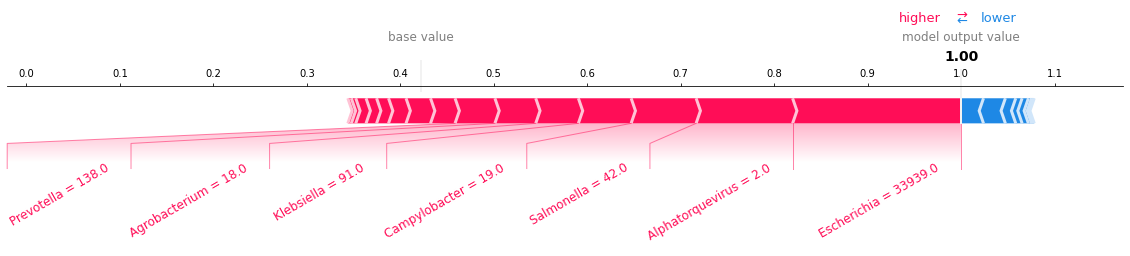

In [9]:
raw_CR = X[['Bacillus', 'Burkholderia', 'Enterococcus', 'Aeromonas', 'Cronobacter',
       'Cytomegalovirus', 'Lymphocryptovirus', 'Campylobacter', 'Pantoea',
       'Shigella', 'Klebsiella', 'Cellulomonas', 'Salmonella', 'Shewanella',
       'Megasphaera', 'Stenotrophomonas', 'Agrobacterium', 'Oerskovia',
       'Prevotella', 'Escherichia', 'Blautia', 'Bacteroides', 'Enterobacter',
       'Alphatorquevirus', 'Veillonella']].copy()

raw_CR_params = {'subsample': 0.8, 'scale_pos_weight': 1.452991452991453, 'n_estimators': 240, 'max_depth': 1, 'gamma': 1.711111111111111, 'colsample_bytree': 0.9052631578947369}
raw_CR_model = XGBClassifier(**raw_CR_params)
raw_CR_model.fit(raw_CR, y)

explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

j = 202

print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])

shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True,
                text_rotation=30)

plt.savefig(results / 'CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')
plt.show()